In [23]:
import pypolychord as pp
from pypolychord.settings import PolyChordSettings as Settings
from mpi4py import MPI
from anesthetic import NestedSamples
import matplotlib.pyplot as plt
import numpy as np

def generate_model(bounds, means, covs):
    thetamin, thetamax = bounds[:,0], bounds[:,1]
    invCov = np.linalg.inv(covs)

    def prior(cube):
        return thetamin + cube * (thetamax - thetamin)

    def log_likelihood(theta):
        return (-(theta - means) @ invCov @ (theta - means) / 2.0 , [])

    return prior, log_likelihood


def higson(samples):
    for x in samples: 
        logX = np.log(samples[x].nlive / (samples[x].nlive + 1)).cumsum()
        LXi = samples[x].logL / samples[x].beta + logX
        LX = np.exp(LXi - LXi.max())
        plt.xlabel(r'$- \log X$')
        plt.ylabel('LX')
        plt.plot(-logX, LX, label=x)
    plt.legend()

bounds = np.array([[-1e6, 1e6], [-1e5, 1e5], [-1e3, 1e3]])
means = np.array([1, 2, 3])
covs = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])

In [11]:
control = generate_model(bounds, means, covs)
settings = Settings(len(means), 0, file_root="unperturbed")
output = pp.run_polychord(control[1], len(means), 0, settings, prior=control[0])

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :      75
nDims    :       3
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/unperturbed.resume

Resuming from previous run
number of repeats:           15
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         2859                              |
| log(Z) =          -30.91165 +/-            0.62148 |
|____________________________________________________|


In [13]:
control_samples = NestedSamples(root='chains/unperturbed')

(<Figure size 432x288 with 12 Axes>,
                                                 0  \
 0  DiagonalAxes(0.125,0.628333;0.258333x0.251667)   
 1   AxesSubplot(0.125,0.376667;0.258333x0.251667)   
 2      AxesSubplot(0.125,0.125;0.258333x0.251667)   
 
                                                    1  \
 0   AxesSubplot(0.383333,0.628333;0.258333x0.251667)   
 1  DiagonalAxes(0.383333,0.376667;0.258333x0.251667)   
 2      AxesSubplot(0.383333,0.125;0.258333x0.251667)   
 
                                                   2  
 0  AxesSubplot(0.641667,0.628333;0.258333x0.251667)  
 1  AxesSubplot(0.641667,0.376667;0.258333x0.251667)  
 2    DiagonalAxes(0.641667,0.125;0.258333x0.251667)  )

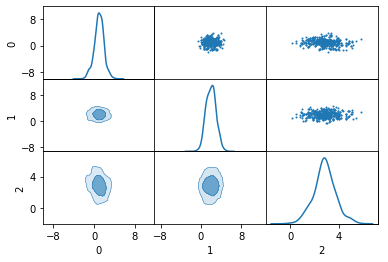

In [15]:
control_samples.plot_2d([0, 1, 2])

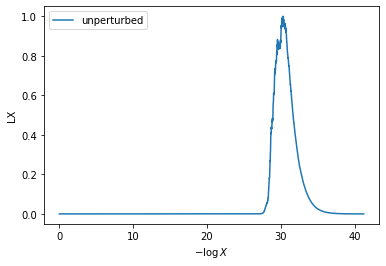

In [24]:
higson({"unperturbed": control_samples})

In [25]:
import supernest as sn

proposal = sn.gaussian_proposal(bounds.T, means, covs, loglike=control[1])

## Perturbing the scale of the covariance matrix